 # Finding the Effect of Controlling Blood Pressure and Cholesterol on Preventing Heart Disease
 
 
 #### By Chris Jung, Grace Wang, Haonan Su
 
 ## Background
***Heart disease*** is the leading cause of death for men, women, and people of most racial and ethnic groups in most of the countries in the world, even in the countries with developed medical technology such as the United States. About 659,000 people in the US die from heart disease each year, which accounts for 1 in every 4 deaths.[[1]](https://www.who.int/health-topics/cardiovascular-diseases).
The US CDC(Centers for Disease Control and Prevention) suggests maintaining low blood pressure and cholesterol to lower the risk of heart disease [[2]](https://www.cdc.gov/heartdisease/prevention.htm).

## Project Question

##### Do people with low blood pressure/cholesterol level have lower chance of developing heart disease?


## Data
- The dataset is an actual medical records from the Cleveland Clinic Foundation stored in the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Heart+Disease).
- Each observation contains 14 attributes of **a person's medical information** including the presence of heart disease.
- The response variable is the attribute "Class".
- The explanatory variables are the attribute "trestpbs"(blood pressure), and "chol"(cholesterol).
- The detailed descriptions of the response variable and the two explanatory variables are:
    1. *class*: presence of heart disease. integer valued from 0 (no presence) to 4
    2. trestbps: resting blood pressure (in mm Hg on admission to the hospital)
    3. chol: serum cholestoral in mg/dl
    

In [2]:
#loads the libraries
library(cowplot)
library(datateachr)
library(digest)
library(infer)
library(repr)
library(taxyvr)
library(tidyverse)

#sets the seed for random events such as splitting the data
set.seed(1)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



## Reading and Wrangling the Data

In [17]:
#reads in the data table with the 14 attributes
heart_data_untidy <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data",
              col_names = FALSE) %>%
              mutate(X12 = as.numeric(X12), X13 = as.numeric(X13))

#outputs the first 6 rows of the data frame
head(heart_data_untidy)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
41,0,2,130,204,0,2,172,0,1.4,1,0,3,0
56,1,2,120,236,0,0,178,0,0.8,1,0,3,0


In [18]:
colnames(heart_data_untidy) <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak",
                          "slope", "ca", "thal", "Class")

#selects the 3 attributes that will be used as explanatory variable(trestbps, and chol) and response variable(Class) 
heart_data_selected <- heart_data_untidy%>%
select(trestbps, chol,  Class)
head(heart_data_selected)


trestbps,chol,Class
<dbl>,<dbl>,<dbl>
145,233,0
160,286,2
120,229,1
130,250,0
130,204,0
120,236,0


In [39]:
#We identify patients' trestbps and chol data higher than 0.5 quantile as 'HIGH' and below 0.5 quantile as 'LOW'
trestbps50 = unname(quantile(heart_data_selected$trestbps,0.5))
chol50 = unname(quantile(heart_data_selected$chol,0.5))
trestbps50
chol50

heart_data_lowhigh <- heart_data_selected %>% 
                        mutate(trestbps = ifelse((trestbps >= trestbps50), "HIGH","LOW"),
                              chol = ifelse(chol > chol50, "HIGH", "LOW"))
                              
#We identified patients with class data higher than 0 as having heart disease and indicated this result 
#with "YES" (and vice versa with "NO"). Also change the data type from number to factor
heart_data <- heart_data_lowhigh %>%
            mutate(Heart_Disease = ifelse(Class > 0, "YES","NO")) %>%
            select(!Class)


#Split heart_data into two data frames
heart_data_trestbps <- heart_data%>%
                       select("trestbps","Heart_Disease")
#outputs the first 6 rows of the data frame and heart_data is the data frame we will eventually use
heart_data_chol <- heart_data%>%
                    select("chol","Heart_Disease")
head(heart_data)
head(heart_data_trestbps)
head(heart_data_chol)

[1] 130

[1] 241

trestbps,chol,Heart_Disease
<chr>,<chr>,<chr>
HIGH,LOW,NO
HIGH,HIGH,YES
LOW,LOW,YES
HIGH,HIGH,NO
HIGH,LOW,NO
LOW,LOW,NO


trestbps,Heart_Disease
<chr>,<chr>
HIGH,NO
HIGH,YES
LOW,YES
HIGH,NO
HIGH,NO
LOW,NO


chol,Heart_Disease
<chr>,<chr>
LOW,NO
HIGH,YES
LOW,YES
HIGH,NO
LOW,NO
LOW,NO


Through the process above, we have converted the data frame into the format we need, which includes all the 
information in the data box about whether the patient has high resting blood pressure or not, whether 
the patient has high cholesterol or not and whether the patient has heart disease or not.

## Visualizing the Data

We first visualized the proportions of heart disease of people with low and high blood pressure and choleterol level as below.

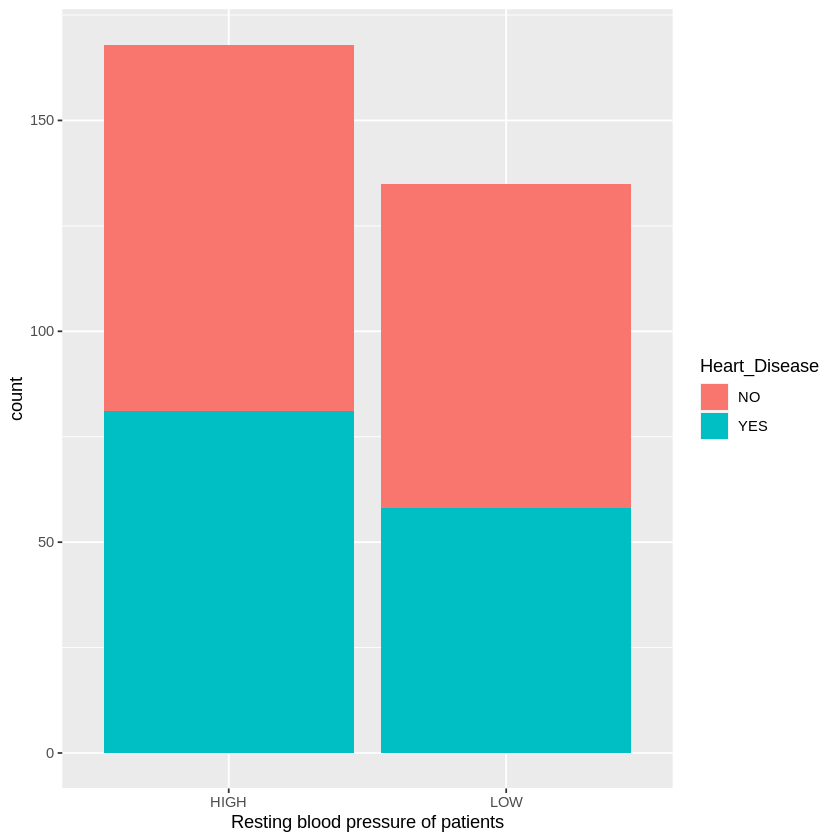

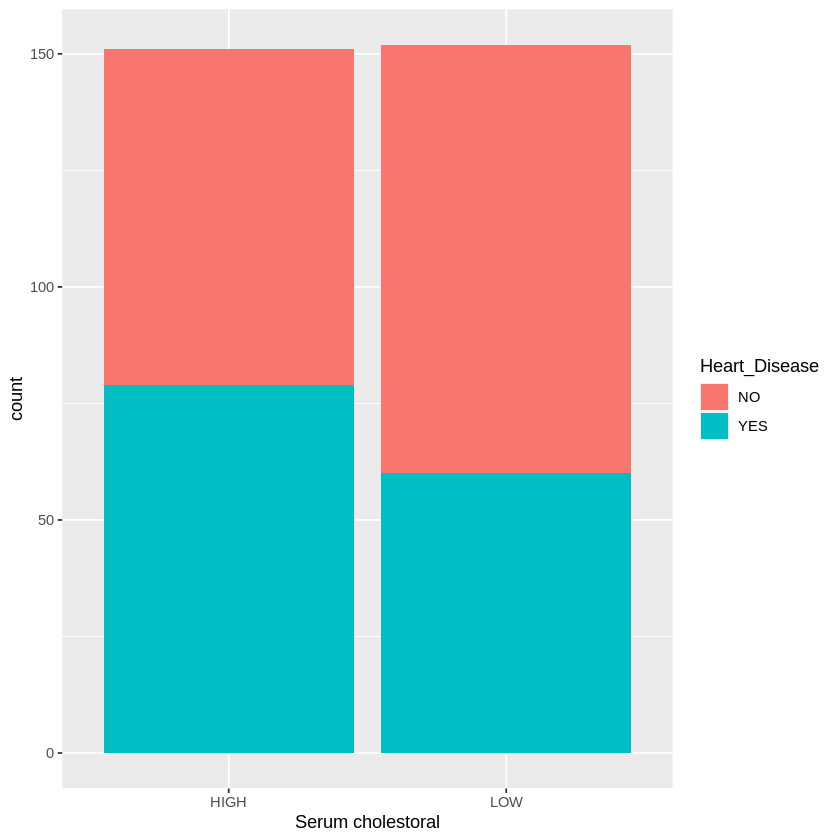

In [40]:
ggplot(heart_data, 
       aes(x = trestbps, fill = Heart_Disease)) +
  geom_bar() + 
  labs(x = "Resting blood pressure of patients")

ggplot(heart_data, 
       aes(x = chol, fill = Heart_Disease)) +
  geom_bar() + 
  labs(x = "Serum cholestoral")

From the both graph, we can rougly see that the proportion of people with heart disease is higher in both high resting blood pressure and cholesterol group compared to the corresponding lower level groups.

## Compute Estimates of the Parameter

Below, we have created three data frame and two tables to summarize the data.

In [67]:
#Generate the percentage of two variables under a four-column combination
heart_data_n <- heart_data %>%
                      tally()%>%
                        pull()

#proportion of the four combinations of low or high resting blood pressure 
#and presence or absence of heart disease.
heart_data_prop_trestbps <-heart_data %>% 
                             group_by(trestbps, Heart_Disease)%>%
                             count() %>% 
                             mutate(p = n/heart_data_n)

#the proportion of the four combinations of the low or high cholesterol and 
#the presence or absence of heart disease.
heart_data_prop_chol <- heart_data %>% 
                          group_by(chol, Heart_Disease)%>%
                          count() %>% 
                          mutate(p = n/heart_data_n)

trest_high_yes <- heart_data_prop_trestbps %>%
                    filter(trestbps=="HIGH", Heart_Disease=="YES")%>% ungroup() %>% select(n) %>% as.numeric()

trest_high_no <- heart_data_prop_trestbps %>%
                    filter(trestbps=="HIGH", Heart_Disease=="NO")%>% ungroup() %>% select(n) %>% as.numeric()

trest_low_yes <- heart_data_prop_trestbps %>%
                    filter(trestbps=="LOW", Heart_Disease=="YES")%>% ungroup() %>% select(n) %>% as.numeric()

trest_low_no <- heart_data_prop_trestbps %>%
                    filter(trestbps=="LOW", Heart_Disease=="NO")%>% ungroup() %>% select(n) %>% as.numeric()

chol_high_yes <- heart_data_prop_chol %>%
                    filter(chol=="HIGH", Heart_Disease=="YES")%>% ungroup() %>% select(n) %>% as.numeric()
chol_high_no <- heart_data_prop_chol %>%
                    filter(chol=="HIGH", Heart_Disease=="NO")%>% ungroup() %>% select(n) %>% as.numeric()
chol_low_yes <- heart_data_prop_chol %>%
                    filter(chol=="LOW", Heart_Disease=="YES")%>% ungroup() %>% select(n) %>% as.numeric()
chol_low_no <- heart_data_prop_chol %>%
                    filter(chol=="LOW", Heart_Disease=="NO")%>% ungroup() %>% select(n) %>% as.numeric()

heart_data_prop_trestbps
heart_data_prop_chol

#Generate the proportion of patients with heart disease with or without high resting blood pressure
Trestbps <- c("HIGH","LOW")
Heart_Disease <- c("YES","YES")
proportion <- c(trest_high_yes/(trest_high_yes+trest_high_no),trest_low_yes/(trest_low_yes+trest_low_no))
heart_data_prop_trestbps_1 <- data.frame(Trestbps,Heart_Disease,proportion)
print(heart_data_prop_trestbps_1)
#Generate the proportion of patients with heart disease with or without high cholesterol
Chol <- c("HIGH","LOW")
proportion <- c(chol_high_yes/(chol_high_yes+chol_high_no),chol_low_yes/(chol_low_yes+chol_low_no))
heart_data_prop_chol_1 <- data.frame(Chol,Heart_Disease,proportion)
print(heart_data_prop_chol_1)


#the estimates after taking 1000 replicates of "shuffles" and assuming the null hypothesis is true
null_distribution <- heart_data %>% 
  specify(formula = Heart_Disease ~ trestbps, success = "YES") %>% 
  hypothesize(null = "independence") %>% 
  generate(reps = 1000, type = "permute") %>% 
  calculate(stat = "diff in props", order = c("HIGH", "LOW"))

head(null_distribution)

trestbps,Heart_Disease,n,p
<chr>,<chr>,<int>,<dbl>
HIGH,NO,87,0.2871287
HIGH,YES,81,0.2673267
LOW,NO,77,0.2541254
LOW,YES,58,0.1914191


chol,Heart_Disease,n,p
<chr>,<chr>,<int>,<dbl>
HIGH,NO,72,0.2376238
HIGH,YES,79,0.2607261
LOW,NO,92,0.3036304
LOW,YES,60,0.1980198


  Trestbps Heart_Disease proportion
1     HIGH           YES  0.4821429
2      LOW           YES  0.4296296
  Chol Heart_Disease proportion
1 HIGH           YES  0.5231788
2  LOW           YES  0.3947368


replicate,stat
<int>,<dbl>
1,-0.12116402
2,0.01243386
3,0.03915344
4,0.05251323
5,0.02579365
6,0.07923280


The differences in the proportion of having heart disease between LOW and HIGH, as reflected in the third and fourth tables, suggest that it would be possible to find out whether high or low resting blood pressure and high or low cholesterol make patients more likely to have heart disease.

## Methods: Plan


Although we perforemd a brief statistical analysis using a large dataset from a reliable source, our preliminary research have following limitations:

- The estimates above were generated using a single sample.
- We cannot compute sampling variation that quantifies the uncertainty about the point estimate obtained from the sample.

### Future Research Plan
- First, we will generate a bootstrap sampling distribution from our sample.
- Then we will conduct the following two hypothesis tests using a confidence interval level at 5%:

> #### Hypothesis Test1

> $p_{1}$ : proportion of people having heart disease with low blood pressure</br>
>$p_{2}$ : proportion of people having heart disease with high blood pressure</br>

>$H_0$ : $p_{2} - p_{1} = 0$  </br>
>$H_1$ : $p_{2} - p_{1} > 0$</br>

>#### Hypothesis Test2

>$p_{3}$ : proportion of people having heart disease with low cholesterol level</br>
>$p_{4}$ : proportion of people having heart disease with high cholesterol level

>$H_0$ : $p_{4} - p_{3} = 0$  </br>
>$H_1$ : $p_{4} - p_{3} > 0$</br>

- Finally, we will analyze the result of hypothesis tests and answer our project question based on it
 
### Expectation

- We expect people with low blood pressure and low cholesterol level would have a lower chance of developing heart disease. 
- Our findings could potentially help raise awareness of the importance of keeping a healthy routine that keeps our blood pressure and cholesterol at a healthy level. 
- Our research could lead to a future question: what is the causation of heart diseases given the correlation we will establish in our report.

### Reference

[1] World Health Organization. (n.d.). Cardiovascular diseases. World Health Organization. Retrieved July 26, 2022, from https://www.who.int/health-topics/cardiovascular-diseases </br>
[2] Centers for Disease Control and Prevention. (2020, April 21). Prevent heart disease. Centers for Disease Control and Prevention. Retrieved July 26, 2022, from https://www.cdc.gov/heartdisease/prevention.htm 